In [154]:
import nltk
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [155]:
data = pd.read_csv("/home/arj/TriSem3/NLP/CIA_Component3/spam.csv",encoding="latin")
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [156]:
data.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [157]:
data=data.drop(columns=["Unnamed: 2","Unnamed: 3","Unnamed: 4"])#dropping the unwanted column

In [158]:
data=data.rename({"v1":"Category","v2":"Message"},axis=1)

In [159]:
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [160]:
data.isnull().sum()

Category    0
Message     0
dtype: int64

In [161]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [162]:
data["Message Length"]=data["Message"].apply(len) #adding an extra column that will have the length of message

In [163]:
data.head()

,Category,Message,Message Length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [164]:
ham_desc=data[data["Category"]=="ham"]["Message Length"].describe()
spam_desc=data[data["Category"]=="spam"]["Message Length"].describe()

In [165]:
print("Ham Messege Length Description:\n",ham_desc)

Ham Messege Length Description:
 count    4825.000000
mean       71.023627
std        58.016023
min         2.000000
25%        33.000000
50%        52.000000
75%        92.000000
max       910.000000
Name: Message Length, dtype: float64


In [166]:
data["Category"].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [167]:
print("Spam Message Length Description:\n",spam_desc)

Spam Message Length Description:
 count    747.000000
mean     138.866131
std       29.183082
min       13.000000
25%      132.500000
50%      149.000000
75%      157.000000
max      224.000000
Name: Message Length, dtype: float64


In [168]:
data.describe(include="all")

,Category,Message,Message Length
count,5572,5572,5572.000000
unique,2,5169,NaN
top,ham,"Sorry, I'll call later",NaN
freq,4825,30,NaN
mean,NaN,NaN,80.118808
std,NaN,NaN,59.690841
min,NaN,NaN,2.000000
25%,NaN,NaN,36.000000
50%,NaN,NaN,61.000000
75%,NaN,NaN,121.000000


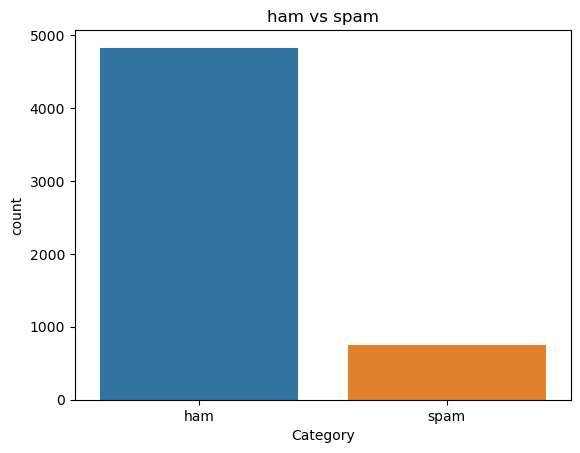

In [169]:
sns.countplot(data=data,x="Category")
plt.title("ham vs spam")
plt.show()

In [170]:
ham_count=data["Category"].value_counts()[0]
spam_count=data["Category"].value_counts()[1]

total_count=data.shape[0]

print("Ham contains:{:.2f}% of total data.".format(ham_count/total_count*100))
print("Spam contains:{:.2f}% of total data.".format(spam_count/total_count*100))

Ham contains:86.59% of total data.
Spam contains:13.41% of total data.


/tmp/ipykernel_266185/3939932709.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ham_count=data["Category"].value_counts()[0]
/tmp/ipykernel_266185/3939932709.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spam_count=data["Category"].value_counts()[1]


In [171]:
#we can see our data is imbalance with 86.59% of data in dataset is ham messages and the 13.41 percent is of spam messages 

In [172]:
# balancing the data

#compute the length of majority & minority class
minority_len=len(data[data["Category"]=="spam"])
majority_len=len(data[data["Category"]=="ham"])

#store the indices of majority and minority class
minority_indices=data[data["Category"]=="spam"].index
majority_indices=data[data["Category"]=="ham"].index

#printing the values
print("minority length: ",minority_len,"\nMajority Length: ",majority_len)
print("minority indices: ",minority_indices,"\nMajority Indices: ",majority_indices)


minority length:  747 
Majority Length:  4825
minority indices:  Index([   2,    5,    8,    9,   11,   12,   15,   19,   34,   42,
       ...
       5492, 5497, 5501, 5524, 5526, 5537, 5540, 5547, 5566, 5567],
      dtype='int64', length=747) 
Majority Indices:  Index([   0,    1,    3,    4,    6,    7,   10,   13,   14,   16,
       ...
       5560, 5561, 5562, 5563, 5564, 5565, 5568, 5569, 5570, 5571],
      dtype='int64', length=4825)


In [173]:
#generate new majority indices from the total majority_indices
#with size equal to minority class length so we obtain equivalent number of indices length
random_majority_indices=np.random.choice(majority_indices,size=minority_len,replace=False)

#concatenate the two indices to obtain indices of new dataframe
undersampled_indices=np.concatenate([minority_indices,random_majority_indices])

df=data.loc[undersampled_indices]#creating df
df=df.sample(frac=1)#shuffling df
df=df.reset_index()
df=df.drop(columns=["index"],)#dropping old index

In [174]:
df.head()

,Category,Message,Message Length
0,ham,"Good afternoon, my boytoy ... How are you feel...",153
1,spam,"This is the 2nd attempt to contract U, you hav...",132
2,spam,Congratulations ur awarded either å£500 of CD ...,150
3,spam,Will u meet ur dream partner soon? Is ur caree...,137
4,ham,Tomarrow final hearing on my laptop case so i ...,51


In [175]:
df.shape

(1494, 3)

In [176]:
df["Category"].value_counts()

Category
ham     747
spam    747
Name: count, dtype: int64

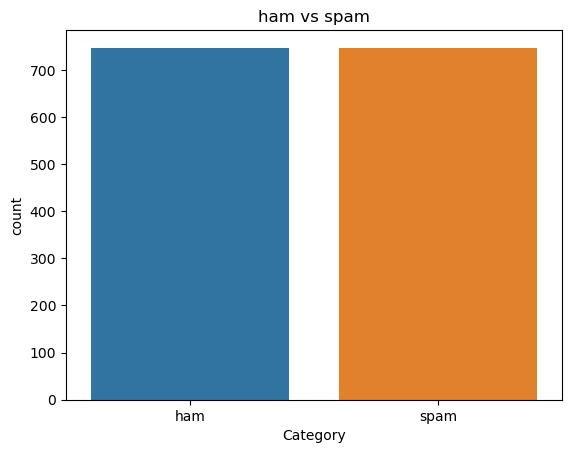

In [177]:
sns.countplot(data=df,x="Category")
plt.title("ham vs spam")
plt.show()

In [178]:
#now our data is balanced as the number of data in ham and spam are equal

In [179]:
df["Label"]=df["Category"].map({"ham":0,"spam":1}) #new column Label and encode ham as 0 and spam as 1

In [180]:
df.head()

,Category,Message,Message Length,Label
0,ham,"Good afternoon, my boytoy ... How are you feel...",153,0
1,spam,"This is the 2nd attempt to contract U, you hav...",132,1
2,spam,Congratulations ur awarded either å£500 of CD ...,150,1
3,spam,Will u meet ur dream partner soon? Is ur caree...,137,1
4,ham,Tomarrow final hearing on my laptop case so i ...,51,0


In [181]:
stemmer=PorterStemmer() #using the stemming method porter

In [182]:
#performing tokenization
corpus=[]
for message in df["Message"]:
    message=re.sub("[^a-zA-Z]"," ",message)
    message=message.lower() #convert every letters to its lowercase
    message=message.split()#split the word into individual word list
    message=[stemmer.stem(words)
            for words in message
             if words not in set(stopwords.words("english"))
            ]#perform stemming using PorterStemmer for all non-english-stopwords
    message=" ".join(message)#join the word lists with the whitespace
    corpus.append(message)#append the message in corpus list

In [183]:
#performing onehot encoding in corpus
vocab_size=10000
oneHot_doc=[one_hot(words,n=vocab_size)for words in corpus]

In [184]:
df["Message Length"].describe()

count    1494.000000
mean      103.699465
std        55.841802
min         2.000000
25%        48.000000
50%       115.500000
75%       153.000000
max       611.000000
Name: Message Length, dtype: float64

/home/arj/anaconda3/envs/clg/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


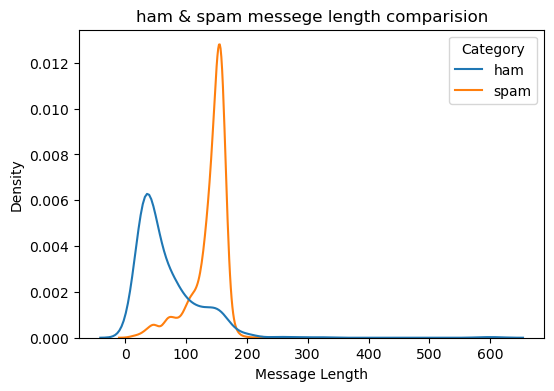

In [185]:
#visualizing message length using kdeplot
fig=plt.figure(figsize=(6,4))
sns.kdeplot(x=df["Message Length"],hue=df["Category"])
plt.title("ham & spam messege length comparision")
plt.show()

In [186]:
# doing Word Embedding using pad sequences
sentence_len=200
embedded_doc=pad_sequences(oneHot_doc,maxlen=sentence_len,padding="pre")

In [187]:
extract_features=pd.DataFrame(data=embedded_doc)# dataframe using embedded doc
target=df["Label"] #target using label

In [188]:
df_last=pd.concat([extract_features,target],axis=1) #concat two dataframe to get final df

In [189]:
df_last.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,Label
0,0,0,0,0,0,0,0,0,0,0,...,7251,3449,9858,5286,498,2607,5653,7447,651,0
1,0,0,0,0,0,0,0,0,0,0,...,2982,5932,9475,874,4307,1644,6107,4307,7397,1
2,0,0,0,0,0,0,0,0,0,0,...,5413,9622,622,4698,3118,9546,6759,3138,3916,1
3,0,0,0,0,0,0,0,0,0,0,...,8796,4748,8647,7880,6844,2819,2841,8796,3892,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1051,8241,8318,5258,2111,6966,0


In [190]:
#split data into train and test
X=df_last.drop("Label",axis=1)
y=df_last["Label"]
X_trainval,X_test,y_trainval,y_test=train_test_split(X,y,random_state=42,test_size=0.15)

In [191]:
#splitted 85% dataset into training and validataion so lets futher split trainval data into training(85%) and validation(15%) dataset.
X_train,X_val,y_train,y_val=train_test_split(X_trainval,y_trainval,random_state=42,test_size=0.15)

In [192]:
#creating the model
model=Sequential()

In [193]:
from tensorflow import keras

In [194]:
feature_num=100
model.add(Embedding(input_dim=vocab_size,output_dim=feature_num,input_length=sentence_len))
model.add(LSTM(units=128))
model.add(Dense(units=1,activation="sigmoid"))
model.compile(optimizer=Adam(learning_rate=0.001),loss="binary_crossentropy", metrics=["accuracy"])
model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=10)

ValueError: Unrecognized keyword arguments passed to Embedding: {'input_length': 200}